Important Libraries

In [2]:
import pandas as pd
import requests
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer
import numpy as np

# Gather
In this process we're going to gather data about the dogs tweets, the data will include three sources.
- The first file: WeRateDog's twitter archive, handed over and downloaded manually from udacity's website.
- The second file: The tweet image predictions, i.e., what breed of dog (or other object, animal, etc.) is present in each tweet according to a neural network, downloaded programatically from udacity's servers
- The third file: Each tweet's retweet count and favorite ("like") count at minimum, queried from Twitter API

**The first file**: twitter-archive-enhanced.csv, downloaded manually from the udacity website, and stored in df_twitter_archive_enhanced using pandas' read_csv() method

In [3]:
df_twitter_archive_enhanced = pd.read_csv('twitter-archive-enhanced.csv')
df_twitter_archive_enhanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

**The second file**: image-predictions.tsv, downloaded programmatically from the udacity website using requests' get() method, then the response is written to image-predictions.tsv file, and stored in df_image_predictions using read_csv()

In [4]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
res = requests.get(url)
file_name = url.split('/')[-1]
with open(file_name, 'wb') as file:
    file.write(res.content)

In [5]:
df_image_predictions = pd.read_csv(file_name, sep='\t')
df_image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


**The third data source**: Each tweet's retweet count and favorite ("like") count at minimum, queried from Twitter API, the API allows us to scrape data easily in the format of JSON

**Three important steps for using the Twitter API:**
- Setup the authentication
- Create a twitter API object
- Query the tweets' retweet count and favourite count using the tweet ids provided in the archive

First of all, the we've got the consumer key, the consumer secret, access token and access secret from creating our own twitter application to access the API, these are hidden in compliance to the user terms

In [6]:
consumer_key = ''
consumer_secret = ''
access_token = ''
access_secret = ''

The next step we're going to do is that we're going to feed the OAuthHandler object "auth" with our consumer and access data

In [7]:
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

Then we're going to create a tweepy API object, with the authentication we've done, and the option to wait if we've exceeded the rate limit of querying tweets

In [8]:
api = tweepy.API(auth, wait_on_rate_limit=True)

Then we're going to use the tweet ids provided in the archive to query the tweet's JSON structures.

In [9]:
tweet_ids = df_twitter_archive_enhanced.tweet_id.values
len(tweet_ids)

2356

Finally to get the last data source, we're going to write the tweets queried by using a loop to iterate over the tweet_ids, and query each of the tweets using the twitter API.
- If a tweet was successfully queried, we're going to write its data to the JSON file.
- If not, we're going to write to the exceptions dictionary.

In [10]:
# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
tweets_list = []
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            tweets_list.append(tweet._json)
            print("Success")
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
    outfile.write(json.dumps(tweets_list, indent=4))
end = timer()
print(end - start)
print(fails_dict)

1: 892420643555336193
Success
2: 892177421306343426
Success
3: 891815181378084864
Success
4: 891689557279858688
Success
5: 891327558926688256
Success
6: 891087950875897856
Success
7: 890971913173991426
Success
8: 890729181411237888
Success
9: 890609185150312448
Success
10: 890240255349198849
Success
11: 890006608113172480
Success
12: 889880896479866881
Success
13: 889665388333682689
Success
14: 889638837579907072
Success
15: 889531135344209921
Success
16: 889278841981685760
Success
17: 888917238123831296
Success
18: 888804989199671297
Success
19: 888554962724278272
Success
20: 888202515573088257
Fail
21: 888078434458587136
Success
22: 887705289381826560
Success
23: 887517139158093824
Success
24: 887473957103951883
Success
25: 887343217045368832
Success
26: 887101392804085760
Success
27: 886983233522544640
Success
28: 886736880519319552
Success
29: 886680336477933568
Success
30: 886366144734445568
Success
31: 886267009285017600
Success
32: 886258384151887873
Success
33: 8860541600590725

**Creating the third DataFrame**
- Now having written the tweets to the JSON file successfully, we're going to read the file and extract what we exactly need: the retweet count, and the favorite count, into a separate dataframe for each tweet, so it can be assessed and merged with the first and second one in the cleaning process.

In [354]:
tweets_list = []
with open('tweet_json.txt', 'r') as json_file:
    all_tweets = json.load(json_file)
    for tweet in all_tweets:
        tweets_list.append({'id':tweet['id'], 
                            'retweet_count': tweet['retweet_count'],
                            'favorite_count': tweet['favorite_count'],
                           })
    df_tweets_api = pd.DataFrame(data=tweets_list, columns=['id', 'retweet_count', 'favorite_count'])
df_tweets_api.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 3 columns):
id                2331 non-null int64
retweet_count     2331 non-null int64
favorite_count    2331 non-null int64
dtypes: int64(3)
memory usage: 54.7 KB


**Joining all data sources**
- In this step we're going to join all the 3 data sources to have a complete dataset of the tweets and to be able to asses and clean the data as one table

In [355]:
df_all_tweets = df_twitter_archive_enhanced.set_index('tweet_id').join(df_tweets_api.set_index('id'))
df_all_tweets = df_all_tweets.join(df_image_predictions.set_index('tweet_id'))
df_all_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 892420643555336193 to 666020888022790149
Data columns (total 29 columns):
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
retweet_count                 2331 non-null float64

# Assess

In this section we're going to (manually and programatically) observe the data, to figure out the flaws in the data in terms of:
- **Quality:** The data being fit for [its] intended uses in operations, decision making and planning 
- **Tidiness:** The requirements for the data to be tidy are: 
        - Each variable forms a column.
        - Each observation forms a row.
        - Each type of observational unit forms a table.

**Steps of Assessment**
- Visual Assessment
- Programmatic Assessment

**The first step** Visual Assessment:

In [356]:
df_twitter_archive_enhanced

tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
0     892420643555336193                    NaN                  NaN   
1     892177421306343426                    NaN                  NaN   
2     891815181378084864                    NaN                  NaN   
3     891689557279858688                    NaN                  NaN   
4     891327558926688256                    NaN                  NaN   
5     891087950875897856                    NaN                  NaN   
6     890971913173991426                    NaN                  NaN   
7     890729181411237888                    NaN                  NaN   
8     890609185150312448                    NaN                  NaN   
9     890240255349198849                    NaN                  NaN   
10    890006608113172480                    NaN                  NaN   
11    889880896479866881                    NaN                  NaN   
12    889665388333682689                    NaN                  NaN   
13    889638837579907072                    NaN                  NaN   
14    889531135344209921                    NaN                  NaN   
15    889278841981685760                    NaN                  NaN   
16    888917238123831296                    NaN                  NaN   
17    888804989199671297                    NaN                  NaN   
18    888554962724278272                    NaN                  NaN   
19    888202515573088257                    NaN                  NaN   
20    888078434458587136                    NaN                  NaN   
21    887705289381826560                    NaN                  NaN   
22    887517139158093824                    NaN                  NaN   
23    887473957103951883                    NaN                  NaN   
24    887343217045368832                    NaN                  NaN   
25    887101392804085760                    NaN                  NaN   
26    886983233522544640                    NaN                  NaN   
27    886736880519319552                    NaN                  NaN   
28    886680336477933568                    NaN                  NaN   
29    886366144734445568                    NaN                  NaN   
...                  ...                    ...                  ...   
2326  666411507551481857                    NaN                  NaN   
2327  666407126856765440                    NaN                  NaN   
2328  666396247373291520                    NaN                  NaN   
2329  666373753744588802                    NaN                  NaN   
2330  666362758909284353                    NaN                  NaN   
2331  666353288456101888                    NaN                  NaN   
2332  666345417576210432                    NaN                  NaN   
2333  666337882303524864                    NaN                  NaN   
2334  666293911632134144                    NaN                  NaN   
2335  666287406224695296                    NaN                  NaN   
2336  666273097616637952                    NaN                  NaN   
2337  666268910803644416                    NaN                  NaN   
2338  666104133288665088                    NaN                  NaN   
2339  666102155909144576                    NaN                  NaN   
2340  666099513787052032                    NaN                  NaN   
2341  666094000022159362                    NaN                  NaN   
2342  666082916733198337                    NaN                  NaN   
2343  666073100786774016                    NaN                  NaN   
2344  666071193221509120                    NaN                  NaN   
2345  666063827256086533                    NaN                  NaN   
2346  666058600524156928                    NaN                  NaN   
2347  666057090499244032                    NaN                  NaN   
2348  666055525042405380                    NaN                  NaN   
2349  666051853826850816                    NaN         

In [357]:
df_image_predictions

tweet_id                                            jpg_url  \
0     666020888022790149    https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg   
1     666029285002620928    https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg   
2     666033412701032449    https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg   
3     666044226329800704    https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg   
4     666049248165822465    https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg   
5     666050758794694657    https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg   
6     666051853826850816    https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg   
7     666055525042405380    https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg   
8     666057090499244032    https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg   
9     666058600524156928    https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg   
10    666063827256086533    https://pbs.twimg.com/media/CT5Vg_wXIAAXfnj.jpg   
11    666071193221509120    https://pbs.twimg.com/media/CT5cN_3WEAAlOoZ.jpg   
12    666073100786774016    https://pbs.twimg.com/media/CT5d9DZXAAALcwe.jpg   
13    666082916733198337    https://pbs.twimg.com/media/CT5m4VGWEAAtKc8.jpg   
14    666094000022159362    https://pbs.twimg.com/media/CT5w9gUW4AAsBNN.jpg   
15    666099513787052032    https://pbs.twimg.com/media/CT51-JJUEAA6hV8.jpg   
16    666102155909144576    https://pbs.twimg.com/media/CT54YGiWUAEZnoK.jpg   
17    666104133288665088    https://pbs.twimg.com/media/CT56LSZWoAAlJj2.jpg   
18    666268910803644416    https://pbs.twimg.com/media/CT8QCd1WEAADXws.jpg   
19    666273097616637952    https://pbs.twimg.com/media/CT8T1mtUwAA3aqm.jpg   
20    666287406224695296    https://pbs.twimg.com/media/CT8g3BpUEAAuFjg.jpg   
21    666293911632134144    https://pbs.twimg.com/media/CT8mx7KW4AEQu8N.jpg   
22    666337882303524864    https://pbs.twimg.com/media/CT9OwFIWEAMuRje.jpg   
23    666345417576210432    https://pbs.twimg.com/media/CT9Vn7PWoAA_ZCM.jpg   
24    666353288456101888    https://pbs.twimg.com/media/CT9cx0tUEAAhNN_.jpg   
25    666362758909284353    https://pbs.twimg.com/media/CT9lXGsUcAAyUFt.jpg   
26    666373753744588802    https://pbs.twimg.com/media/CT9vZEYWUAAlZ05.jpg   
27    666396247373291520    https://pbs.twimg.com/media/CT-D2ZHWIAA3gK1.jpg   
28    666407126856765440    https://pbs.twimg.com/media/CT-NvwmW4AAugGZ.jpg   
29    666411507551481857    https://pbs.twimg.com/media/CT-RugiWIAELEaq.jpg   
...                  ...                                                ...   
2045  886366144734445568    https://pbs.twimg.com/media/DE0BTnQUwAApKEH.jpg   
2046  886680336477933568    https://pbs.twimg.com/media/DE4fEDzWAAAyHMM.jpg   
2047  886736880519319552    https://pbs.twimg.com/media/DE5Se8FXcAAJFx4.jpg   
2048  886983233522544640    https://pbs.twimg.com/media/DE8yicJW0AAAvBJ.jpg   
2049  887101392804085760    https://pbs.twimg.com/media/DE-eAq6UwAA-jaE.jpg   
2050  887343217045368832  https://pbs.twimg.com/ext_tw_video_thumb/88734...   
2051  887473957103951883    https://pbs.twimg.com/media/DFDw2tyUQAAAFke.jpg   
2052  887517139158093824  https://pbs.twimg.com/ext_tw_video_thumb/88751...   
2053  887705289381826560    https://pbs.twimg.com/media/DFHDQBbXgAEqY7t.jpg   
2054  888078434458587136    https://pbs.twimg.com/media/DFMWn56WsAAkA7B.jpg   
2055  888202515573088257    https://pbs.twimg.com/media/DFDw2tyUQAAAFke.jpg   
2056  888554962724278272    https://pbs.twimg.com/media/DFTH_O-UQAACu20.jpg   
2057  888804989199671297    https://pbs.twimg.com/media/DFWra-3VYAA2piG.jpg   
2058  888917238123831296    https://pbs.twimg.com/media/DFYRgsOUQAARGhO.jpg   
2059  889278841981685760  https://pbs.twimg.com/ext_tw_video_thumb/88927...   
2060  889531135344209921    https://pbs.twimg.com/media/DFg_2PVW0AEHN3p.jpg   
2061  889638837579907072    https://pbs.twimg.com/media/DFihzFfXsAYGDPR.jpg   
2062  889665388333682689    https://pbs.twimg.com/media/DFi579UWsAAatzw.jpg   
2063  889880896479866881    https://pbs.twimg.com/media/DFl99B1WsA

In [358]:
df_tweets_api

id  retweet_count  favorite_count
0     892420643555336193           7464           35362
1     892177421306343426           5543           30604
2     891815181378084864           3667           23031
3     891689557279858688           7641           38663
4     891327558926688256           8239           36927
5     891087950875897856           2758           18625
6     890971913173991426           1791           10819
7     890729181411237888          16700           59581
8     890609185150312448           3813           25629
9     890240255349198849           6479           29246
10    890006608113172480           6490           28192
11    889880896479866881           4411           25648
12    889665388333682689           8852           44026
13    889638837579907072           3962           24778
14    889531135344209921           1997           13933
15    889278841981685760           4713           23129
16    888917238123831296           3974           26742
17    888804989199671297           3743           23472
18    888554962724278272           3060           18093
19    888078434458587136           3071           19989
20    887705289381826560           4779           27806
21    887517139158093824          10423           42574
22    887473957103951883          15911           63007
23    887343217045368832           9322           30912
24    887101392804085760           5274           28128
25    886983233522544640           6768           31938
26    886736880519319552           2820           10976
27    886680336477933568           3961           20655
28    886366144734445568           2802           19391
29    886267009285017600              4             110
...                  ...            ...             ...
2301  666411507551481857            286             397
2302  666407126856765440             31              98
2303  666396247373291520             73             155
2304  666373753744588802             78             169
2305  666362758909284353            502             702
2306  666353288456101888             64             193
2307  666345417576210432            128             267
2308  666337882303524864             81             179
2309  666293911632134144            312             450
2310  666287406224695296             57             131
2311  666273097616637952             70             157
2312  666268910803644416             32              94
2313  666104133288665088           5812           13290
2314  666102155909144576             11              69
2315  666099513787052032             57             140
2316  666094000022159362             66             153
2317  666082916733198337             41             100
2318  666073100786774016            141             285
2319  666071193221509120             52             134
2320  666063827256086533            191             438
2321  666058600524156928             51             103
2322  666057090499244032            120             262
2323  666055525042405380            214             404
2324  666051853826850816            752            1098
2325  666050758794694657             51             121
2326  666049248165822465             39              96
2327  666044226329800704            124             265
2328  666033412701032449             39             109
2329  666029285002620928             41             119
2330  666020888022790149            448            2356

[2331 rows x 3 columns]

df_all_tweets

In [359]:
df_all_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 892420643555336193 to 666020888022790149
Data columns (total 29 columns):
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
retweet_count                 2331 non-null float64

**The second step**: Programmatic Assessment

In [360]:
df_all_tweets.rating_numerator.unique(), df_all_tweets.rating_denominator.unique()

(array([  13,   12,   14,    5,   17,   11,   10,  420,  666,    6,   15,
         182,  960,    0,   75,    7,   84,    9,   24,    8,    1,   27,
           3,    4,  165, 1776,  204,   50,   99,   80,   45,   60,   44,
         143,  121,   20,   26,    2,  144,   88]),
 array([ 10,   0,  15,  70,   7,  11, 150, 170,  20,  50,  90,  80,  40,
        130, 110,  16, 120,   2]))

In [361]:
sum(df_all_tweets['jpg_url'].duplicated())

346

From this assessment we can find out there are some quality issues, such as:
- **Quality Issues**

    1. Some tweets in this dataset are not actual tweets, they're retweets only, so we need to keep the original ones
    2. Some NULL values are interpreted as "None" and "NAN" 
    3. Some columns don't contribute much to the data set, columns such as: 

            - in_reply_to_status_id
            - in_reply_to_user_id
            - retweeted_status_id 
            - retweeted_status_user_id
            - retweeted_status_timestamp

    4. Some columns need to be converted to represent a true/false encoding, such as: 

            - doggo
            - floofer
            - pupper
            - puppo

    5. For every dog, the rating numerator sometimes exceed 15, also the rating denominator sometimes exceed 10.
    6. Duplicate image url 
    7. No image url
    8. Accuracy
     >Many of the name values are incorrectly set to words from the text value when they should be 'None'.

    
- **Tidiness Issues**
    1. For every dog, the dog's breed needs to be determined from the columns:

            - p1, p1_conf, p1_dog
            - p2_p2_conf, p2_dog
            - p3, p3_conf, p3_dog
            
    2. For every dog, the dog's age stage needs to be determined from the columns: 
            - doggo
            - floofer
            - pupper
            - puppo

# Clean
In this stage we're going to solve the quality and tidiness issues that we found out in the Assert section, 

**The first Quality issue**: Some tweets in this dataset are not actual tweets, they're retweets only, so we need to keep the original ones

In [362]:
df_all_tweets = df_all_tweets[pd.isnull(df_all_tweets['retweeted_status_user_id'])]
sum(df_all_tweets.retweeted_status_user_id.value_counts())


0

**The second Quality issue**: Unify all null values to be NAN

In [363]:
df_all_tweets.replace('None', np.nan, inplace=True)

**The third Quality issue**: Remove columns that don't contribute much to the data, e.g. too many null values

In [364]:
df_all_tweets.drop(columns=['in_reply_to_status_id',
                            'in_reply_to_user_id',
                            'retweeted_status_id',
                            'retweeted_status_user_id',
                            'retweeted_status_timestamp'],inplace=True)
df_all_tweets.head()

timestamp  \
tweet_id                                        
892420643555336193  2017-08-01 16:23:56 +0000   
892177421306343426  2017-08-01 00:17:27 +0000   
891815181378084864  2017-07-31 00:18:03 +0000   
891689557279858688  2017-07-30 15:58:51 +0000   
891327558926688256  2017-07-29 16:00:24 +0000   

                                                               source  \
tweet_id                                                                
892420643555336193  <a href="http://twitter.com/download/iphone" r...   
892177421306343426  <a href="http://twitter.com/download/iphone" r...   
891815181378084864  <a href="http://twitter.com/download/iphone" r...   
891689557279858688  <a href="http://twitter.com/download/iphone" r...   
891327558926688256  <a href="http://twitter.com/download/iphone" r...   

                                                                 text  \
tweet_id                                                                
892420643555336193  This is Phineas. He's a mystical boy. Only eve...   
892177421306343426  This is Tilly. She's just checking pup on you....   
891815181378084864  This is Archie. He is a rare Norwegian Pouncin...   
891689557279858688  This is Darla. She commenced a snooze mid meal...   
891327558926688256  This is Franklin. He would like you to stop ca...   

                                                        expanded_urls  \
tweet_id                                                                
892420643555336193  https://twitter.com/dog_rates/status/892420643...   
892177421306343426  https://twitter.com/dog_rates/status/892177421...   
891815181378084864  https://twitter.com/dog_rates/status/891815181...   
891689557279858688  https://twitter.com/dog_rates/status/891689557...   
891327558926688256  https://twitter.com/dog_rates/status/891327558...   

                    rating_numerator  rating_denominator      name doggo  \
tweet_id                                                                   
892420643555336193                13                  10   Phineas   NaN   
892177421306343426                13                  10     Tilly   NaN   
891815181378084864                12                  10    Archie   NaN   
891689557279858688                13                  10     Darla   NaN   
891327558926688256                12                  10  Franklin   NaN   

                   floofer pupper   ...   img_num           p1   p1_conf  \
tweet_id                            ...                                    
892420643555336193     NaN    NaN   ...       1.0       orange  0.097049   
892177421306343426     NaN    NaN   ...       1.0    Chihuahua  0.323581   
891815181378084864     NaN    NaN   ...       1.0    Chihuahua  0.716012   
891689557279858688     NaN    NaN   ...       1.0  paper_towel  0.170278   
891327558926688256     NaN    NaN   ...       2.0       basset  0.555712   

                   p1_dog                  p2   p2_conf  p2_dog  \
tweet_id                                                          
892420643555336193  False               bagel  0.085851   False   
892177421306343426   True            Pekinese  0.090647    True   
891815181378084864   True            malamute  0.078253    True   
891689557279858688  False  Labrador_retriever  0.168086    True   
891327558926688256   True    English_springer  0.225770    True   

                                             p3   p3_conf  p3_dog  
tweet_id                                                           
892420643555336193                       banana  0.076110   False  
892177421306343426                     papillon  0.068957    True  
891815181378084864                       kelpie  0.031379    True  
891689557279858688                      spatula  0.040836   False  
891327558926688256  German_short-haired_pointer  0.175219    True  

[5 rows x 24 columns]

**The fourth Quality issue**: Some columns need to be converted to represent a true/false encoding

In [365]:
df_all_tweets.doggo.replace(np.nan, False,inplace=True)
df_all_tweets.floofer.replace(np.nan, False,inplace=True)
df_all_tweets.pupper.replace(np.nan, False,inplace=True)
df_all_tweets.puppo.replace(np.nan, False,inplace=True)

df_all_tweets.doggo.replace('doggo', True,inplace=True)
df_all_tweets.floofer.replace('floofer', True,inplace=True)
df_all_tweets.pupper.replace('pupper', True,inplace=True)
df_all_tweets.puppo.replace('puppo', True,inplace=True)

**The fifth Quality issue**: For every dog, the rating denominator is not always 10

In [366]:
df_all_tweets.loc[df_all_tweets.rating_denominator != 10, 'rating_denominator'] = 10

In [367]:
df_all_tweets.rating_numerator.unique(), df_all_tweets.rating_denominator.unique() 

(array([  13,   12,   14,    5,   17,   11,   10,  420,  666,    6,  182,
          15,  960,    0,    7,   84,   24,   75,   27,    3,    8,    9,
           4,  165, 1776,  204,   50,   99,   80,   45,   60,   44,    1,
         143,  121,   20,   26,    2,  144,   88]), array([10]))

In [368]:
df_all_tweets['rating'] = df_all_tweets.rating_numerator / df_all_tweets.rating_denominator
df_all_tweets.drop(columns=['rating_numerator', 'rating_denominator'])

timestamp  \
tweet_id                                        
892420643555336193  2017-08-01 16:23:56 +0000   
892177421306343426  2017-08-01 00:17:27 +0000   
891815181378084864  2017-07-31 00:18:03 +0000   
891689557279858688  2017-07-30 15:58:51 +0000   
891327558926688256  2017-07-29 16:00:24 +0000   
891087950875897856  2017-07-29 00:08:17 +0000   
890971913173991426  2017-07-28 16:27:12 +0000   
890729181411237888  2017-07-28 00:22:40 +0000   
890609185150312448  2017-07-27 16:25:51 +0000   
890240255349198849  2017-07-26 15:59:51 +0000   
890006608113172480  2017-07-26 00:31:25 +0000   
889880896479866881  2017-07-25 16:11:53 +0000   
889665388333682689  2017-07-25 01:55:32 +0000   
889638837579907072  2017-07-25 00:10:02 +0000   
889531135344209921  2017-07-24 17:02:04 +0000   
889278841981685760  2017-07-24 00:19:32 +0000   
888917238123831296  2017-07-23 00:22:39 +0000   
888804989199671297  2017-07-22 16:56:37 +0000   
888554962724278272  2017-07-22 00:23:06 +0000   
888078434458587136  2017-07-20 16:49:33 +0000   
887705289381826560  2017-07-19 16:06:48 +0000   
887517139158093824  2017-07-19 03:39:09 +0000   
887473957103951883  2017-07-19 00:47:34 +0000   
887343217045368832  2017-07-18 16:08:03 +0000   
887101392804085760  2017-07-18 00:07:08 +0000   
886983233522544640  2017-07-17 16:17:36 +0000   
886736880519319552  2017-07-16 23:58:41 +0000   
886680336477933568  2017-07-16 20:14:00 +0000   
886366144734445568  2017-07-15 23:25:31 +0000   
886267009285017600  2017-07-15 16:51:35 +0000   
...                                       ...   
666411507551481857  2015-11-17 00:24:19 +0000   
666407126856765440  2015-11-17 00:06:54 +0000   
666396247373291520  2015-11-16 23:23:41 +0000   
666373753744588802  2015-11-16 21:54:18 +0000   
666362758909284353  2015-11-16 21:10:36 +0000   
666353288456101888  2015-11-16 20:32:58 +0000   
666345417576210432  2015-11-16 20:01:42 +0000   
666337882303524864  2015-11-16 19:31:45 +0000   
666293911632134144  2015-11-16 16:37:02 +0000   
666287406224695296  2015-11-16 16:11:11 +0000   
666273097616637952  2015-11-16 15:14:19 +0000   
666268910803644416  2015-11-16 14:57:41 +0000   
666104133288665088  2015-11-16 04:02:55 +0000   
666102155909144576  2015-11-16 03:55:04 +0000   
666099513787052032  2015-11-16 03:44:34 +0000   
666094000022159362  2015-11-16 03:22:39 +0000   
666082916733198337  2015-11-16 02:38:37 +0000   
666073100786774016  2015-11-16 01:59:36 +0000   
666071193221509120  2015-11-16 01:52:02 +0000   
666063827256086533  2015-11-16 01:22:45 +0000   
666058600524156928  2015-11-16 01:01:59 +0000   
666057090499244032  2015-11-16 00:55:59 +0000   
666055525042405380  2015-11-16 00:49:46 +0000   
666051853826850816  2015-11-16 00:35:11 +0000   
666050758794694657  2015-11-16 00:30:50 +0000   
666049248165822465  2015-11-16 00:24:50 +0000   
666044226329800704  2015-11-16 00:04:52 +0000   
666033412701032449  2015-11-15 23:21:54 +0000   
666029285002620928  2015-11-15 23:05:30 +0000   
666020888022790149  2015-11-15 22:32:08 +0000   

                                                               source  \
tweet_id                                                                
892420643555336193  <a href="http://twitter.com/download/iphone" r...   
892177421306343426  <a href="http://twitter.com/download/iphone" r...   
891815181378084864  <a href="http://twitter.com/download/iphone" r...   
891689557279858688  <a href="http://twitter.com/download/iphone" r...   
891327558926688256  <a href="http://twitter.com/download/iphone" r...   
891087950875897856  <a href="http://twitter.com/download/iphone" r...   
890971913173991426  <a href="http://twitter.com/download/iphone" r...   
890729181411237888  <a href="http://twitter.com/download/iphone" r...   
890609185150312448  <a href="http://twitter.com/download/iphone" r...   
890240255349198849  <a href="http://twitter.com/download/iphone" r...   
890006608113172480  <a href="http://twitter.com/download/iphone" r...   

**The sixth Quality issue** Duplicate image url

In [369]:
# image_prediction_clean = image_prediction_clean.drop_duplicates(subset=['jpg_url'], keep='last')
df_all_tweets.drop_duplicates(subset=['jpg_url'],keep='last')

timestamp  \
tweet_id                                        
892420643555336193  2017-08-01 16:23:56 +0000   
892177421306343426  2017-08-01 00:17:27 +0000   
891815181378084864  2017-07-31 00:18:03 +0000   
891689557279858688  2017-07-30 15:58:51 +0000   
891327558926688256  2017-07-29 16:00:24 +0000   
891087950875897856  2017-07-29 00:08:17 +0000   
890971913173991426  2017-07-28 16:27:12 +0000   
890729181411237888  2017-07-28 00:22:40 +0000   
890609185150312448  2017-07-27 16:25:51 +0000   
890240255349198849  2017-07-26 15:59:51 +0000   
890006608113172480  2017-07-26 00:31:25 +0000   
889880896479866881  2017-07-25 16:11:53 +0000   
889665388333682689  2017-07-25 01:55:32 +0000   
889638837579907072  2017-07-25 00:10:02 +0000   
889531135344209921  2017-07-24 17:02:04 +0000   
889278841981685760  2017-07-24 00:19:32 +0000   
888917238123831296  2017-07-23 00:22:39 +0000   
888804989199671297  2017-07-22 16:56:37 +0000   
888554962724278272  2017-07-22 00:23:06 +0000   
888078434458587136  2017-07-20 16:49:33 +0000   
887705289381826560  2017-07-19 16:06:48 +0000   
887517139158093824  2017-07-19 03:39:09 +0000   
887473957103951883  2017-07-19 00:47:34 +0000   
887343217045368832  2017-07-18 16:08:03 +0000   
887101392804085760  2017-07-18 00:07:08 +0000   
886983233522544640  2017-07-17 16:17:36 +0000   
886736880519319552  2017-07-16 23:58:41 +0000   
886680336477933568  2017-07-16 20:14:00 +0000   
886366144734445568  2017-07-15 23:25:31 +0000   
886258384151887873  2017-07-15 16:17:19 +0000   
...                                       ...   
666411507551481857  2015-11-17 00:24:19 +0000   
666407126856765440  2015-11-17 00:06:54 +0000   
666396247373291520  2015-11-16 23:23:41 +0000   
666373753744588802  2015-11-16 21:54:18 +0000   
666362758909284353  2015-11-16 21:10:36 +0000   
666353288456101888  2015-11-16 20:32:58 +0000   
666345417576210432  2015-11-16 20:01:42 +0000   
666337882303524864  2015-11-16 19:31:45 +0000   
666293911632134144  2015-11-16 16:37:02 +0000   
666287406224695296  2015-11-16 16:11:11 +0000   
666273097616637952  2015-11-16 15:14:19 +0000   
666268910803644416  2015-11-16 14:57:41 +0000   
666104133288665088  2015-11-16 04:02:55 +0000   
666102155909144576  2015-11-16 03:55:04 +0000   
666099513787052032  2015-11-16 03:44:34 +0000   
666094000022159362  2015-11-16 03:22:39 +0000   
666082916733198337  2015-11-16 02:38:37 +0000   
666073100786774016  2015-11-16 01:59:36 +0000   
666071193221509120  2015-11-16 01:52:02 +0000   
666063827256086533  2015-11-16 01:22:45 +0000   
666058600524156928  2015-11-16 01:01:59 +0000   
666057090499244032  2015-11-16 00:55:59 +0000   
666055525042405380  2015-11-16 00:49:46 +0000   
666051853826850816  2015-11-16 00:35:11 +0000   
666050758794694657  2015-11-16 00:30:50 +0000   
666049248165822465  2015-11-16 00:24:50 +0000   
666044226329800704  2015-11-16 00:04:52 +0000   
666033412701032449  2015-11-15 23:21:54 +0000   
666029285002620928  2015-11-15 23:05:30 +0000   
666020888022790149  2015-11-15 22:32:08 +0000   

                                                               source  \
tweet_id                                                                
892420643555336193  <a href="http://twitter.com/download/iphone" r...   
892177421306343426  <a href="http://twitter.com/download/iphone" r...   
891815181378084864  <a href="http://twitter.com/download/iphone" r...   
891689557279858688  <a href="http://twitter.com/download/iphone" r...   
891327558926688256  <a href="http://twitter.com/download/iphone" r...   
891087950875897856  <a href="http://twitter.com/download/iphone" r...   
890971913173991426  <a href="http://twitter.com/download/iphone" r...   
890729181411237888  <a href="http://twitter.com/download/iphone" r...   
890609185150312448  <a href="http://twitter.com/download/iphone" r...   
890240255349198849  <a href="http://twitter.com/download/iphone" r...   
890006608113172480  <a href="http://twitter.com/download/iphone" r...   

**The Seventh Quality issue**: No image url

In [370]:
df_all_tweets.dropna(subset=['jpg_url'])


timestamp  \
tweet_id                                        
892420643555336193  2017-08-01 16:23:56 +0000   
892177421306343426  2017-08-01 00:17:27 +0000   
891815181378084864  2017-07-31 00:18:03 +0000   
891689557279858688  2017-07-30 15:58:51 +0000   
891327558926688256  2017-07-29 16:00:24 +0000   
891087950875897856  2017-07-29 00:08:17 +0000   
890971913173991426  2017-07-28 16:27:12 +0000   
890729181411237888  2017-07-28 00:22:40 +0000   
890609185150312448  2017-07-27 16:25:51 +0000   
890240255349198849  2017-07-26 15:59:51 +0000   
890006608113172480  2017-07-26 00:31:25 +0000   
889880896479866881  2017-07-25 16:11:53 +0000   
889665388333682689  2017-07-25 01:55:32 +0000   
889638837579907072  2017-07-25 00:10:02 +0000   
889531135344209921  2017-07-24 17:02:04 +0000   
889278841981685760  2017-07-24 00:19:32 +0000   
888917238123831296  2017-07-23 00:22:39 +0000   
888804989199671297  2017-07-22 16:56:37 +0000   
888554962724278272  2017-07-22 00:23:06 +0000   
888078434458587136  2017-07-20 16:49:33 +0000   
887705289381826560  2017-07-19 16:06:48 +0000   
887517139158093824  2017-07-19 03:39:09 +0000   
887473957103951883  2017-07-19 00:47:34 +0000   
887343217045368832  2017-07-18 16:08:03 +0000   
887101392804085760  2017-07-18 00:07:08 +0000   
886983233522544640  2017-07-17 16:17:36 +0000   
886736880519319552  2017-07-16 23:58:41 +0000   
886680336477933568  2017-07-16 20:14:00 +0000   
886366144734445568  2017-07-15 23:25:31 +0000   
886258384151887873  2017-07-15 16:17:19 +0000   
...                                       ...   
666411507551481857  2015-11-17 00:24:19 +0000   
666407126856765440  2015-11-17 00:06:54 +0000   
666396247373291520  2015-11-16 23:23:41 +0000   
666373753744588802  2015-11-16 21:54:18 +0000   
666362758909284353  2015-11-16 21:10:36 +0000   
666353288456101888  2015-11-16 20:32:58 +0000   
666345417576210432  2015-11-16 20:01:42 +0000   
666337882303524864  2015-11-16 19:31:45 +0000   
666293911632134144  2015-11-16 16:37:02 +0000   
666287406224695296  2015-11-16 16:11:11 +0000   
666273097616637952  2015-11-16 15:14:19 +0000   
666268910803644416  2015-11-16 14:57:41 +0000   
666104133288665088  2015-11-16 04:02:55 +0000   
666102155909144576  2015-11-16 03:55:04 +0000   
666099513787052032  2015-11-16 03:44:34 +0000   
666094000022159362  2015-11-16 03:22:39 +0000   
666082916733198337  2015-11-16 02:38:37 +0000   
666073100786774016  2015-11-16 01:59:36 +0000   
666071193221509120  2015-11-16 01:52:02 +0000   
666063827256086533  2015-11-16 01:22:45 +0000   
666058600524156928  2015-11-16 01:01:59 +0000   
666057090499244032  2015-11-16 00:55:59 +0000   
666055525042405380  2015-11-16 00:49:46 +0000   
666051853826850816  2015-11-16 00:35:11 +0000   
666050758794694657  2015-11-16 00:30:50 +0000   
666049248165822465  2015-11-16 00:24:50 +0000   
666044226329800704  2015-11-16 00:04:52 +0000   
666033412701032449  2015-11-15 23:21:54 +0000   
666029285002620928  2015-11-15 23:05:30 +0000   
666020888022790149  2015-11-15 22:32:08 +0000   

                                                               source  \
tweet_id                                                                
892420643555336193  <a href="http://twitter.com/download/iphone" r...   
892177421306343426  <a href="http://twitter.com/download/iphone" r...   
891815181378084864  <a href="http://twitter.com/download/iphone" r...   
891689557279858688  <a href="http://twitter.com/download/iphone" r...   
891327558926688256  <a href="http://twitter.com/download/iphone" r...   
891087950875897856  <a href="http://twitter.com/download/iphone" r...   
890971913173991426  <a href="http://twitter.com/download/iphone" r...   
890729181411237888  <a href="http://twitter.com/download/iphone" r...   
890609185150312448  <a href="http://twitter.com/download/iphone" r...   
890240255349198849  <a href="http://twitter.com/download/iphone" r...   
890006608113172480  <a href="http://twitter.com/download/iphone" r...   

**The eighth Quality issue:** :Accuracy
>Many of the name values are incorrectly set to words from the text value when they should be 'None'.


In [371]:
df_all_tweets.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 892420643555336193 to 666020888022790149
Data columns (total 25 columns):
timestamp             2175 non-null object
source                2175 non-null object
text                  2175 non-null object
expanded_urls         2117 non-null object
rating_numerator      2175 non-null int64
rating_denominator    2175 non-null int64
name                  1495 non-null object
doggo                 2175 non-null bool
floofer               2175 non-null bool
pupper                2175 non-null bool
puppo                 2175 non-null bool
retweet_count         2168 non-null float64
favorite_count        2168 non-null float64
jpg_url               1994 non-null object
img_num               1994 non-null float64
p1                    1994 non-null object
p1_conf               1994 non-null float64
p1_dog                1994 non-null object
p2                    1994 non-null object
p2_conf               1994 non-null float64
p2_dog 

In [372]:

names_to_check = []
for index, row in df_all_tweets.iterrows():
    
    if str(row['name']) not in(row['text']) and row['name'] != 'None':
        names_to_check.append(index)

names_to_check


[891087950875897856,
 890729181411237888,
 889665388333682689,
 887343217045368832,
 887101392804085760,
 886267009285017600,
 885518971528720385,
 885167619883638784,
 884441805382717440,
 884247878851493888,
 883117836046086144,
 881633300179243008,
 880872448815771648,
 880095782870896641,
 879674319642796034,
 878604707211726852,
 876537666061221889,
 875097192612077568,
 875021211251597312,
 874057562936811520,
 873580283840344065,
 872967104147763200,
 872820683541237760,
 872486979161796608,
 871102520638267392,
 870804317367881728,
 870726314365509632,
 868622495443632128,
 867900495410671616,
 867051520902168576,
 866720684873056260,
 864873206498414592,
 863427515083354112,
 863079547188785154,
 862096992088072192,
 861288531465048066,
 860184849394610176,
 859607811541651456,
 859074603037188101,
 858843525470990336,
 857393404942143489,
 857214891891077121,
 856526610513747968,
 856288084350160898,
 855862651834028034,
 855860136149123072,
 855857698524602368,
 855851453814

In [373]:
names_change = []
for index, row in df_all_tweets.iterrows():
    if str(row['name'])[0].islower():
        names_change.append(index)
len(names_change)

784

In [374]:

for index in names_change:
    df_all_tweets.at[index, 'name'] = 'None'
names_change = []
for index, row in df_all_tweets.iterrows():
    if str(row['name'])[0].islower():
        names_change.append(index)

len(names_change)


0

**The first Tidiness issue**: For every dog, the dog's breed needs to be determined from the columns

In [375]:
#CODE: the first true prediction (p1, p2 or p3) will be store in these lists
type_of_dogs = []
conf_list = []

#create a function with nested if to capture the dog type and confidence level
# from the first 'true' prediction
def images(df_all_tweets):
    if df_all_tweets['p1_dog'] == True:
        type_of_dogs.append(df_all_tweets['p1'])
        conf_list.append(df_all_tweets['p1_conf'])
    elif df_all_tweets['p2_dog'] == True:
        type_of_dogs.append(df_all_tweets['p2'])
        conf_list.append(df_all_tweets['p2_conf'])
    elif df_all_tweets['p3_dog'] == True:
        type_of_dogs.append(df_all_tweets['p3'])
        conf_list.append(df_all_tweets['p3_conf'])
    else:
        type_of_dogs.append('Error')
        conf_list.append('Error')

#series objects having index the image_prediction_clean column.        
df_all_tweets.apply(images, axis=1)

#create new columns
df_all_tweets['dog_type'] = type_of_dogs
df_all_tweets['confidence_list'] = conf_list

In [376]:

#drop rows that has prediction 'error'
df_all_tweets = df_all_tweets[df_all_tweets['dog_type'] != 'Error']
df_all_tweets.drop(columns=['p1','p1_dog','p1_conf','p2','p2_dog','p2_conf','p3','p3_dog','p3_conf'],inplace=True)

#TEST: 
df_all_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1686 entries, 892177421306343426 to 666020888022790149
Data columns (total 18 columns):
timestamp             1686 non-null object
source                1686 non-null object
text                  1686 non-null object
expanded_urls         1686 non-null object
rating_numerator      1686 non-null int64
rating_denominator    1686 non-null int64
name                  1686 non-null object
doggo                 1686 non-null bool
floofer               1686 non-null bool
pupper                1686 non-null bool
puppo                 1686 non-null bool
retweet_count         1679 non-null float64
favorite_count        1679 non-null float64
jpg_url               1686 non-null object
img_num               1686 non-null float64
rating                1686 non-null float64
dog_type              1686 non-null object
confidence_list       1686 non-null object
dtypes: bool(4), float64(4), int64(2), object(8)
memory usage: 204.2+ KB


**The second Tidiness issue**: For every dog, the dog's age stage needs to be determined from the columns
 - doggo
 - floofer
 - pupper
 - puppo

In [377]:

df_all_tweets[['doggo','floofer','pupper','puppo']].sum(axis=1).unique()


array([0, 1, 2])

In [378]:
df_all_tweets['multi_age_stage'] = df_all_tweets[['doggo','floofer','pupper','puppo']].sum(axis=1) == 2
age_stage = df_all_tweets.query('multi_age_stage == True')[['text', 'doggo','floofer','pupper','puppo']]
age_stage.shape

(10, 5)

In [379]:
age_stage.to_csv('multiple_age_stage.csv')

In [380]:
age_stage.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 855851453814013952 to 733109485275860992
Data columns (total 5 columns):
text       10 non-null object
doggo      10 non-null bool
floofer    10 non-null bool
pupper     10 non-null bool
puppo      10 non-null bool
dtypes: bool(4), object(1)
memory usage: 200.0+ bytes


In [381]:
df_all_tweets['dog_type'].value_counts()

golden_retriever                  158
Labrador_retriever                108
Pembroke                           95
Chihuahua                          91
pug                                62
toy_poodle                         51
chow                               48
Pomeranian                         42
Samoyed                            42
malamute                           33
French_bulldog                     31
Chesapeake_Bay_retriever           31
cocker_spaniel                     30
miniature_pinscher                 25
Eskimo_dog                         22
Cardigan                           21
Staffordshire_bullterrier          21
German_shepherd                    21
Shih-Tzu                           20
Siberian_husky                     20
beagle                             20
Rottweiler                         19
Shetland_sheepdog                  19
Maltese_dog                        19
Lakeland_terrier                   18
kuvasz                             18
basset      

****Data Visualization****

In [382]:
import matplotlib.pyplot as plt


In [383]:
df_all_tweets.plot(kind="scatter",x="rating",y="favorite_count",c=["red"],s=60,alpha=0.4,title = "rating VS favorite count")

In [384]:

df_all_tweets.plot(kind="scatter",x="retweet_count",y="favorite_count",c=["y"],s=60,alpha=0.4,title = "rating VS favorite count")

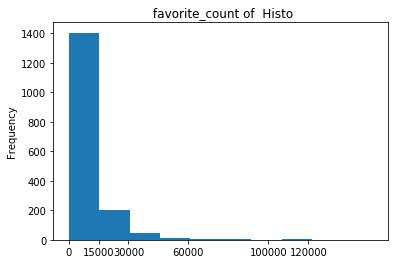

In [385]:
df_all_tweets.favorite_count.plot(kind="hist",title= " favorite_count of  Histo",xticks=[0,15000,30000,60000,100000,120000])
